In [1]:
from bs4 import BeautifulSoup
import requests
import re
import json
import ee
import pandas as pd

ee.Initialize()

In [2]:
def get_credentials(url):
    req = requests.get(url) # "https://ryali93.users.earthengine.app/view/plateaapi"
    soup = BeautifulSoup(req.content, 'html.parser')
    data = soup.find_all('script')[3]
    match = re.search(r'{.*}', data.string)
    creds = json.loads(match.group(0))
    return creds

def create_query(lon_min, lat_min, lon_max, lat_max, start_date, end_date):
    # Cargar el conjunto de datos Sentinel-2
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterDate(start_date, end_date) \
        .filterBounds(ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max]))

    # Calcular el NDVI y el NDMI
    def calc_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    def calc_ndmi(image):
        ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
        return image.addBands(ndmi)

    # Calcular la media del NDVI y NDMI en la región
    def reduce_region(image):
        mean = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max]), scale=10)
        return image.set('NDVI', mean.get('NDVI')).set('NDMI', mean.get('NDMI'))

    sentinel2_ndvi_ndmi = sentinel2.map(calc_ndvi).map(calc_ndmi)

    sentinel2_ndvi_ndmi_mean = sentinel2_ndvi_ndmi.map(reduce_region).select(['NDVI', 'NDMI'])
    # Extraer la serie de tiempo de las medias de NDVI y NDMI en la región
    series = sentinel2_ndvi_ndmi_mean.filter(ee.Filter.notNull(['NDVI', 'NDMI'])).getRegion(ee.Geometry.Point(lon_min, lat_min), 10).getInfo()

    data = ee.String.encodeJSON(series)

    return data.serialize()

def get_data(creds, expression):
    url = 'https://content-earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute'

    headers = {
        'authority': 'content-earthengine.googleapis.com',
        'authorization': f'Bearer {creds["authToken"]}',
        'content-type': 'application/json',
        'origin': 'https://ryali93.users.earthengine.app',   # https://jstnbraaten.users.earthengine.app
        'referer': 'https://ryali93.users.earthengine.app/', # https://jstnbraaten.users.earthengine.app
    }

    data = json.dumps({"expression": json.loads(expression)})
    response = requests.post(url, headers=headers, data=data)
    d = json.loads(response.text)
    return json.loads(d["result"])

In [3]:
lon_min = -5.237967983411331
lat_min = 40.14995437234561
lon_max = -5.23282495763253
lat_max = 40.15291829085358
start_date = "2023-02-06"
end_date = "2023-05-16"

creds = get_credentials("https://ryali93.users.earthengine.app/view/plateaapi") # "https://ryali93.users.earthengine.app/view/plateaapi"
expression = create_query(lon_min, lat_min, lon_max, lat_max, start_date, end_date)
data = get_data(creds, expression)

In [4]:
df = pd.DataFrame(data[1:], columns=data[0])
df['date'] = pd.to_datetime(df['time'], unit='ms').dt.strftime('%Y-%m-%d')
df = df[['date', 'NDVI', 'NDMI']]
df.head()

,date,NDVI,NDMI
0,2023-02-10,0.430343,0.133948
1,2023-02-10,0.423591,0.131466
2,2023-02-15,0.396212,0.136743
3,2023-02-15,0.391375,0.132075
4,2023-02-20,0.227610,0.175609


In [34]:
# transform to json
df.to_json(orient='records')

'[{"date":"2023-02-10","NDVI":0.4303429568,"NDMI":0.1339477727},{"date":"2023-02-10","NDVI":0.4235909355,"NDMI":0.1314655172},{"date":"2023-02-15","NDVI":0.3962118284,"NDMI":0.1367427223},{"date":"2023-02-15","NDVI":0.3913751017,"NDMI":0.1320754717},{"date":"2023-02-20","NDVI":0.2276103102,"NDMI":0.1756092459},{"date":"2023-02-20","NDVI":0.2,"NDMI":0.2209440698},{"date":"2023-02-25","NDVI":0.430179388,"NDMI":0.1556060821},{"date":"2023-02-25","NDVI":0.446035627,"NDMI":0.1616161616},{"date":"2023-03-02","NDVI":0.4484962406,"NDMI":0.141798785},{"date":"2023-03-02","NDVI":0.449444549,"NDMI":0.1399378054},{"date":"2023-03-07","NDVI":-0.0004116921,"NDMI":0.2069844032},{"date":"2023-03-07","NDVI":0.0,"NDMI":0.2077151335},{"date":"2023-03-12","NDVI":0.3542074364,"NDMI":0.1288743883},{"date":"2023-03-12","NDVI":0.359223301,"NDMI":0.1307039978},{"date":"2023-03-17","NDVI":0.4500875657,"NDMI":0.1675126904},{"date":"2023-03-17","NDVI":0.4457831325,"NDMI":0.1698219836},{"date":"2023-03-22","NDVI":

In [35]:
import requests

In [41]:
url = 'https://earthengine.googleapis.com/v1alpha/projects/rgee-267600/tables/ee5fa4a7ef7f31cb58e5662151e10e88-dab1d913993d8f69b4c1cc7629a25cf7:getFeatures'
response = requests.get(url)
# Comprobamos que la petición se ha realizado correctamente
if response.status_code == 200:
    # Escribimos el contenido al archivo .kml
    with open('archivo.kml', 'wb') as f:
        f.write(response.content)
else:
    print(f'Error al descargar el archivo: {response.status_code}')

In [5]:
def create_query_flood(lon_min, lat_min, lon_max, lat_max, start_date, end_date):
    # Create AOI
    aoi = ee.Geometry.Rectangle([[lon_min, lat_min],[lon_max, lat_max]])

    # Define a default start date (preflood | during flood)
    start_date = [ee.Date(start_date), ee.Date(end_date)]
    advance_days = [60, 8]

    # Define a function to smoothen the raster and export the shapefile
    def getFloodShpUrl(floodLayer, value, radius, aoi, cellSize):
        # Define a boxcar or low-pass kernel.
        boxcar = ee.Kernel.square(radius, 'pixels', True)
        smooth_flood = floodLayer.eq(value).convolve(boxcar)
        smooth_flood_binary = smooth_flood.updateMask(smooth_flood.gt(0.5)).gt(0)
        vectors = smooth_flood_binary.reduceToVectors(
            geometry=aoi,
            crs=floodLayer.projection(),
            scale=cellSize,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='zone',
            maxPixels=9e12
        )
        flood_vector = ee.FeatureCollection(vectors)
        return flood_vector

    def getFloodImage(s1_collection_t1, s1_collection_t2):
        zvv_thd = -3
        zvh_thd = -3
        pow_thd = 75

        z_iwasc = calc_zscore(s1_collection_t1, s1_collection_t2)
        z = ee.ImageCollection.fromImages([z_iwasc]).sort('system:time_start')
        floods = mapFloods(z.mean(), zvv_thd, zvh_thd, pow_thd)
        return floods.clip(aoi)

    def getSentinel1WithinDateRange(date, span):
        filters = [
            ee.Filter.listContains("transmitterReceiverPolarisation", "VV"),
            ee.Filter.listContains("transmitterReceiverPolarisation", "VH"),
            ee.Filter.Or(
                ee.Filter.equals("instrumentMode", "IW"),
                ee.Filter.equals("instrumentMode", "SM")
            ),
            ee.Filter.bounds(aoi),
            ee.Filter.eq('resolution_meters', 10),
            ee.Filter.date(date, date.advance(span+1, 'day'))
        ]

        s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD').filter(filters)
        return s1_collection
    
    def createS1Composite(s1_collection):
        composite = ee.Image.cat([
            s1_collection.select('VH').mean(),
            s1_collection.select('VV').mean(),
            s1_collection.select('VH').mean()
        ])
        return composite.clip(aoi)

    def maskS2clouds(image):
        qa = image.select('QA60')

        # Bits 10 and 11 are clouds and cirrus, respectively.
        cloudBitMask = 1 << 10
        cirrusBitMask = 1 << 11

        # Both flags should be set to zero, indicating clear conditions.
        mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

        return image.updateMask(mask)
    
    def getSentinel2WithinDateRange(date, span):
        sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
            .filterBounds(aoi) \
            .filterDate(date, date.advance(span+1, 'day')) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 70)) \
            .map(maskS2clouds) \
            .select('B4', 'B3', 'B2')
                        
        return sentinel2.mean().clip(aoi)
    
    def getS1Image(index):
        s1_collection = getSentinel1WithinDateRange(start_date[index], advance_days[index])
        return createS1Composite(s1_collection)

    def getS2Image(index):
        return getSentinel2WithinDateRange(start_date[index], advance_days[index])

    def calc_zscore(s1_collection_t1, s1_image_t2):
        anom = s1_image_t2 \
            .mean() \
            .subtract(s1_collection_t1.mean()) \
            .set({'system:time_start': s1_image_t2.get('system:time_start')})
        
        basesd = s1_collection_t1 \
            .reduce(ee.Reducer.stdDev()) \
            .rename(['VV', 'VH', 'angle'])
        
        return anom.divide(basesd) \
            .set({'system:time_start': anom.get('system:time_start')})

    def mapFloods(z, zvv_thd=-3, zvh_thd=-3, pow_thd=75, elev_thd=800, slp_thd=15):
        # JRC water mask
        jrc = ee.ImageCollection("JRC/GSW1_1/MonthlyHistory").filterDate('2016-01-01', '2019-01-01')
        jrcvalid = jrc.map(lambda x: x.gt(0)).sum()
        jrcwat = jrc.map(lambda x: x.eq(2)).sum().divide(jrcvalid).multiply(100)
        jrcmask = jrcvalid.gt(0)
        ow = jrcwat.gte(ee.Image(pow_thd))

        # add elevation and slope masking
        elevation = ee.Image('USGS/SRTMGL1_003').select('elevation')
        slope = ee.Terrain.slope(elevation)

        # Classify floods
        vvflag = z.select('VV').lte(ee.Image(zvv_thd))
        vhflag = z.select('VH').lte(ee.Image(zvh_thd))

        flood_class = ee.Image(0) \
            .add(vvflag) \
            .add(vhflag.multiply(2)) \
            .where(ow.eq(1), 4) \
            .rename('flood_class') \
            .where(elevation.gt(elev_thd).And(ow.neq(1)), 0) \
            .where(slope.gt(slp_thd).And(ow.neq(1)), 0)

        return flood_class

    flood = getFloodImage(getSentinel1WithinDateRange(start_date[0], advance_days[0]), 
                          getSentinel1WithinDateRange(start_date[1], advance_days[1]))
    flood_vector = getFloodShpUrl(flood, 3, 3, aoi, 10)
    vector_url = flood_vector.getDownloadURL(
        filetype = 'kml',
        filename = "flood"
        )
    return vector_url

In [6]:
a = [[-4.806366833818512, 41.71218968728039],
    [-4.806366833818512, 41.572873990551464],
    [-4.641915234697418, 41.572873990551464],
    [-4.641915234697418, 41.71218968728039]]

# get lon_min, lat_min, lon_max, lat_max from a
lon_min = a[0][0]
lat_min = a[0][1]
lon_max = a[2][0]
lat_max = a[2][1]
# lon_min = -5.237967983411331
# lat_min = 40.14995437234561
# lon_max = -5.23282495763253
# lat_max = 40.15291829085358
start_date = '2016-07-01'
end_date = '2022-10-16'
url_kml = create_query_flood(lon_min, lat_min, lon_max, lat_max, start_date, end_date)

In [7]:
url_kml

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/tables/68ec8515e117048e06e40d07c57acb93-7100fc43e1d8d930cf0bac10ba84fbd2:getFeatures'

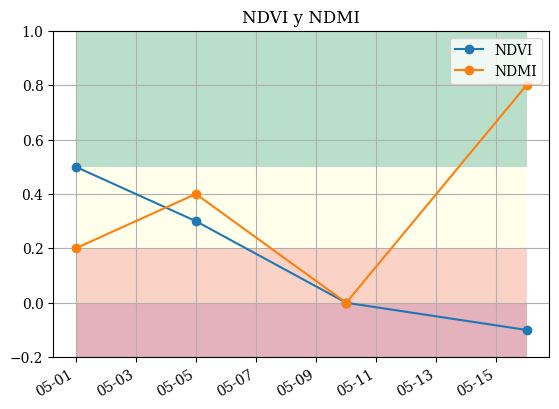

In [23]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

time = ['2023-05-01', '2023-05-05', '2023-05-10', '2023-05-16']
time = [datetime.strptime(d, '%Y-%m-%d') for d in time]

ndvi = [0.5, 0.3, 0, -0.1]
ndmi = [0.2, 0.4, 0, 0.8]

ranges = [(-0.2, 0), (0, 0.2), (0.2, 0.5), (0.5, 1)]
colors = ['#a50026', '#f46d43', '#ffffbf', '#1a9850']

fig, ax = plt.subplots()  # Crear la figura y los ejes aquí

ax.plot(time, ndvi, marker='o', label='NDVI')
ax.plot(time, ndmi, marker='o', label='NDMI')

ax.set_title('NDVI y NDMI')
ax.set_ylim([-0.2, 1])

for color, range in zip(colors, ranges):
    ax.fill_between(time, range[0], range[1], facecolor=color, alpha=0.3)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Usa AutoDateLocator para manejar automáticamente los ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Formatea los ticks como deseas

fig.autofmt_xdate()  # Hace que los ticks en el eje x sean más legibles
ax.legend()  # Añade una leyenda
ax.grid()  # Añade una cuadrícula

fig.savefig('test.png')
plt.show()  # Muestra la figura
